In [1]:
# 导入常用库
import os
import glob
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
sns.set(style="whitegrid")
# ---- Matplotlib 中文字体配置 ----
# 尝试找到系统中常见的中文字体并设置为默认字体，防止中文在图片中显示为方块
def _set_chinese_font():
    candidates = [
        'STHeiti',
        'PingFang SC',
        'AppleGothic',
        'Heiti SC',
        'SimHei',
        'Noto Sans CJK SC',
        'WenQuanYi Zen Hei',
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            matplotlib.rcParams['font.sans-serif'] = [name]
            plt.rcParams['font.sans-serif'] = [name]
            matplotlib.rcParams['axes.unicode_minus'] = False
            plt.rcParams['axes.unicode_minus'] = False
            print(f'Matplotlib Chinese font set to: {name}')
            try:
                return font_manager.findfont(name, fallback_to_default=False)
            except Exception:
                return None
    matplotlib.rcParams['axes.unicode_minus'] = False
    plt.rcParams['axes.unicode_minus'] = False
    print('Warning: 未找到常见中文字体，图中中文可能无法正常显示。可安装 Noto Sans CJK 或者在系统中添加中文字体。')
    return None
wordcloud_font_path = _set_chinese_font()
if not wordcloud_font_path:
    try:
        default_font = font_manager.findfont(matplotlib.rcParams['font.sans-serif'][0])
        if os.path.exists(default_font):
            wordcloud_font_path = default_font
    except Exception:
        wordcloud_font_path = None
if not wordcloud_font_path:
    print('Warning: 未能确认词云使用的字体文件，词云可能无法正常显示中文。')
# 确保保存图片目录存在（与 boss 分析一致目录）
os.makedirs('./website/data/picture', exist_ok=True)

Matplotlib Chinese font set to: SimHei


In [2]:
# 读取 qianchengwuyou 目录下的所有 CSV/Excel 文件并合并（兼容多格式）
data_dir = './qianchengwuyou/data'
files_csv = glob.glob(os.path.join(data_dir, '*.csv'))
files_xlsx = glob.glob(os.path.join(data_dir, '*.xlsx'))
dfs = []
for f in files_csv:
    try:
        dfs.append(pd.read_csv(f, dtype=str, engine='python'))
    except Exception as e:
        try:
            dfs.append(pd.read_csv(f, dtype=str))
        except:
            print(f'读取失败: {f} ->', e)
for f in files_xlsx:
    try:
        dfs.append(pd.read_excel(f, dtype=str))
    except Exception as e:
        print(f'读取失败: {f} ->', e)
if len(dfs) == 0:
    raise FileNotFoundError(f'在 {data_dir} 未发现可读取的文件')
df = pd.concat(dfs, ignore_index=True).replace({np.nan: None})
# 去重并查看基本信息
df = df.drop_duplicates().reset_index(drop=True)
print('合并后记录数:', len(df))
df.head()

合并后记录数: 7138


,职位,薪资,城市,经验,学历,公司,公司领域,公司性质,公司规模,福利标签,技能标签,岗位描述
0,产品经理,1-1.6万·13薪,佛山·顺德区,5年及以上,本科,青岛海信模具有限公司,机械/设备/重工,国企,500-1000人,年终奖金;项目提成,办公软件;数据分析;cad;项目管理;office;方案设计;产品开发;功能设计;市场调查;调研,None
1,项目产品工程师,8千-1.2万·14薪,湖州,3年及以上,大专,湖州剑力金属制品有限公司,汽车,外资（非欧美）,1000-5000人,None,项目管理;产品开发;项目计划;机械工程;五大工具;产品开发流程;产品项目管理;项目案例;分析...,None
2,电力智能运维产品经理,2.5-3.5万·14薪,南京·江宁区,5年及以上,本科,江苏金智科技股份有限公司,计算机软件,民营,1000-5000人,None,研发;市场分析;电力行业;售前技术支持;需求收集;产品管理;调研分析;智能运维;智能巡检;智...,None
3,产品工程师（base保定）,1.2-2万·15薪,保定,无需经验,大专,前锦网络信息技术（上海）有限公司,专业服务(咨询、人力资源、财会),合资,5000-10000人,社保缴纳;五险一金;补充医疗保险;带薪年假;带薪病假,产品设计;产品工程师;机械设计;汽车零部件;项目开发;全职,None
4,助理产品经理,1.2-1.5万·13薪,成都,3年及以上,本科,莫仕连接器（成都）有限公司,电子技术/半导体/集成电路,外资（欧美）,1000-5000人,五险一金;定期体检;商业意外险;年终奖金;绩效奖金;餐饮补贴;通讯补贴;交通补贴,车载连接器;产品管理,None


In [3]:
# 统计各文件原始行数与去重情况
file_counts = {}
for path in files_csv:
    name = os.path.basename(path)
    try:
        temp_df = pd.read_csv(path, dtype=str, engine='python')
    except Exception:
        temp_df = pd.read_csv(path, dtype=str)
    file_counts[name] = len(temp_df)
for path in files_xlsx:
    name = os.path.basename(path)
    temp_df = pd.read_excel(path, dtype=str)
    file_counts[name] = len(temp_df)
# 计算合并前后的行数
raw_total = sum(file_counts.values())
dedup_total = len(df)
dup_removed = raw_total - dedup_total
print('原始合并行数:', raw_total)
print('去重后行数:', dedup_total)
print('去重数量:', dup_removed)
print('各文件行数预览:')
for name, count in sorted(file_counts.items()):
    print(f'  {name}: {count}')

原始合并行数: 9000
去重后行数: 7138
去重数量: 1862
各文件行数预览:
  产品.csv: 1000
  保险.csv: 1000
  基金经理.csv: 1000
  投行.csv: 1000
  数据分析.csv: 1000
  证券研究所.csv: 1000
  财务.csv: 1000
  运营.csv: 1000
  银行.csv: 1000


In [4]:
# 统一列名容错：常见列名映射（如果原数据列名不同，可在此扩展）
col_map = {
    '职位': '职位', '职位名称': '职位',
    '岗位名称': '职位',
    '薪资': '薪资', '工资': '薪资',
    '薪酬': '薪资',
    '学历': '学历', '最低学历': '学历',
    '经验': '经验', '工作经验': '经验',
    '职位描述': '职位描述', '岗位职责': '职位描述', '岗位描述': '职位描述', '职位信息': '职位描述',
    '技能标签': '技能标签', '技能': '技能标签', '关键字': '技能标签',
    '地区': '地区', '工作地点': '地区', '城市': '地区',
    '公司名称': '公司',
    '福利标签': '福利标签', '福利': '福利标签',
    '岗位要求': '职位描述补充'
}
# 应用映射（仅当标准列名不存在时才重命名）
for original, standard in col_map.items():
    if original in df.columns and (standard not in df.columns or df[standard].isna().all()):
        df = df.rename(columns={original: standard})
# 若存在补充描述列，将其并入职位描述
if '职位描述补充' in df.columns:
    if '职位描述' in df.columns:
        df['职位描述'] = df['职位描述'].fillna('') + df['职位描述补充'].fillna('')
    else:
        df['职位描述'] = df['职位描述补充']
    df = df.drop(columns=['职位描述补充'])
# 确保关键列存在
for key in ['薪资','学历','经验','职位描述','技能标签','地区','公司规模']:
    if key not in df.columns:
        df[key] = None
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7138 entries, 0 to 7137
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   职位      7138 non-null   object
 1   薪资      7088 non-null   object
 2   地区      7106 non-null   object
 3   经验      7138 non-null   object
 4   学历      6849 non-null   object
 5   公司      7138 non-null   object
 6   公司领域    7138 non-null   object
 7   公司性质    7137 non-null   object
 8   公司规模    7138 non-null   object
 9   福利标签    6067 non-null   object
 10  技能标签    5915 non-null   object
 11  职位描述    2704 non-null   object
dtypes: object(12)
memory usage: 669.3+ KB


In [5]:
# 检查原始列名与样例数据，帮助确认文本字段来源
sample_path = files_csv[0] if files_csv else files_xlsx[0]
sample_df = pd.read_csv(sample_path, dtype=str, engine='python') if sample_path.endswith('.csv') else pd.read_excel(sample_path, dtype=str)
print('样例文件:', os.path.basename(sample_path))
print('列名:', list(sample_df.columns))
display(sample_df.head(2).T)

样例文件: 产品.csv
列名: ['职位', '薪资', '城市', '经验', '学历', '公司', '公司领域', '公司性质', '公司规模', '福利标签', '技能标签', '岗位描述']


,0,1
职位,产品经理,项目产品工程师
薪资,1-1.6万·13薪,8千-1.2万·14薪
城市,佛山·顺德区,湖州
经验,5年及以上,3年及以上
学历,本科,大专
公司,青岛海信模具有限公司,湖州剑力金属制品有限公司
公司领域,机械/设备/重工,汽车
公司性质,国企,外资（非欧美）
公司规模,500-1000人,1000-5000人
福利标签,年终奖金;项目提成,NaN


In [6]:
# 清理薪资，统一为平均月薪 (单位: K/月)，支持常见格式：10-15K、8千-1万/月、10-15K·13薪、20-30万/年、300-500元/天 等
def clean_salary(salary_str):
    if pd.isna(salary_str):
        return None
    s = str(salary_str).replace('\u200b', '').strip()
    if not s:
        return None
    if any(flag in s for flag in ['面议', '待定', '无', '--']):
        return None
    # 提取发薪月份数，例如 ·13薪
    bonus = 12
    bonus_match = re.search(r'(\d+)\s*薪', s)
    if bonus_match:
        bonus = float(bonus_match.group(1))
    s_clean = re.sub(r'(\d+)\s*薪', '', s)
    s_clean = s_clean.replace('以上', '').replace('以下', '').replace('起', '')
    s_clean = s_clean.replace('>', '').replace('<', '')
    s_clean = s_clean.replace('—', '-').replace('–', '-').replace('至', '-')
    s_clean = s_clean.replace('·', '').replace('／', '/')
    s_clean = s_clean.replace('元/月', '元/月').replace('元天', '元/天')
    s_clean = s_clean.replace('万年', '万/年').replace('万元年', '万/年')
    s_clean = s_clean.replace('千月', '千/月').replace('千年', '千/年')
    s_clean = s_clean.replace('万月', '万/月')
    s_clean = s_clean.replace('元天', '元/天')
    period = '月'
    if re.search(r'年', s_clean) and re.search(r'(/年|年薪)', s_clean):
        period = '年'
    elif re.search(r'(天|日)', s_clean):
        period = '天'
    elif re.search(r'(小时|时)', s_clean):
        period = '小时'
    def unit_factor(unit, fallback=None):
        unit = unit or fallback
        if not unit:
            return 1
        unit = unit.lower()
        if unit in ['万', 'w']:
            return 10
        if unit in ['千', 'k', '千元', '千/月', '千年'] or unit.startswith('千'):
            return 1
        if unit in ['元'] or '元' in unit:
            return 0.001
        if unit in ['k']:
            return 1
        return 1
    range_pattern = re.search(r'(\d+(?:\.\d+)?)(万|千|k|K|w|W|元)?\s*-\s*(\d+(?:\.\d+)?)(万|千|k|K|w|W|元)?', s_clean)
    single_pattern = re.search(r'(\d+(?:\.\d+)?)(万|千|k|K|w|W|元)?', s_clean)
    avg = None
    if range_pattern:
        low_str, low_unit, high_str, high_unit = range_pattern.groups()
        low = float(low_str) * unit_factor(low_unit, high_unit or low_unit)
        high = float(high_str) * unit_factor(high_unit, low_unit or high_unit)
        avg = (low + high) / 2
    elif single_pattern:
        num_str, unit = single_pattern.groups()
        avg = float(num_str) * unit_factor(unit)
    else:
        return None
    if period == '年':
        avg = avg / 12
    elif period == '天':
        avg = avg * 21.75
    elif period == '小时':
        avg = avg * 21.75 * 8
    if bonus != 12 and period == '月':
        avg = avg * (bonus / 12)
    return round(avg, 2)
# 应用并过滤空薪资
df['avg_salary'] = df['薪资'].apply(clean_salary)
df = df.dropna(subset=['avg_salary']).reset_index(drop=True)
print('清洗后有效记录数:', len(df))
df['avg_salary'] = df['avg_salary'].astype(float)
df.head()

清洗后有效记录数: 7088


,职位,薪资,地区,经验,学历,公司,公司领域,公司性质,公司规模,福利标签,技能标签,职位描述,avg_salary
0,产品经理,1-1.6万·13薪,佛山·顺德区,5年及以上,本科,青岛海信模具有限公司,机械/设备/重工,国企,500-1000人,年终奖金;项目提成,办公软件;数据分析;cad;项目管理;office;方案设计;产品开发;功能设计;市场调查;调研,None,14.08
1,项目产品工程师,8千-1.2万·14薪,湖州,3年及以上,大专,湖州剑力金属制品有限公司,汽车,外资（非欧美）,1000-5000人,None,项目管理;产品开发;项目计划;机械工程;五大工具;产品开发流程;产品项目管理;项目案例;分析...,None,11.67
2,电力智能运维产品经理,2.5-3.5万·14薪,南京·江宁区,5年及以上,本科,江苏金智科技股份有限公司,计算机软件,民营,1000-5000人,None,研发;市场分析;电力行业;售前技术支持;需求收集;产品管理;调研分析;智能运维;智能巡检;智...,None,35.00
3,产品工程师（base保定）,1.2-2万·15薪,保定,无需经验,大专,前锦网络信息技术（上海）有限公司,专业服务(咨询、人力资源、财会),合资,5000-10000人,社保缴纳;五险一金;补充医疗保险;带薪年假;带薪病假,产品设计;产品工程师;机械设计;汽车零部件;项目开发;全职,None,20.00
4,助理产品经理,1.2-1.5万·13薪,成都,3年及以上,本科,莫仕连接器（成都）有限公司,电子技术/半导体/集成电路,外资（欧美）,1000-5000人,五险一金;定期体检;商业意外险;年终奖金;绩效奖金;餐饮补贴;通讯补贴;交通补贴,车载连接器;产品管理,None,14.62


In [7]:
# 学历与经验映射（可根据需要调整）
edu_map = {
    '学历不限': 0, '不限': 0, '初中': 0.5, '高中': 1, '中专': 1, '中技': 1,
    '大专': 2, '专科': 2, '本科': 3, '硕士': 4, '研究生': 4, '博士': 5
}
exp_map = {
    '经验不限': 0, '不限': 0, '无经验': 0, '在校/应届': 0,
    '1年以内': 0.5, '一年以内': 0.5,
    '1-3年': 2, '一至三年': 2,
    '3-5年': 4, '三年以上': 4,
    '5-10年': 7.5, '五年以上': 7.5,
    '10年以上': 12
}
def map_edu(x):
    if pd.isna(x) or x is None:
        return 0
    text = str(x)
    for key, value in edu_map.items():
        if key in text:
            return value
    if '硕' in text:
        return 4
    if '博' in text:
        return 5
    if '本' in text:
        return 3
    if '专' in text:
        return 2
    return 0
def map_exp(x):
    if pd.isna(x) or x is None:
        return 0
    text = str(x)
    for key, value in exp_map.items():
        if key in text:
            return value
    match_year = re.search(r'(\d+)', text)
    if match_year:
        val = int(match_year.group(1))
        if '个月' in text and val < 12:
            return 0.5
        return min(val, 15)
    return 0
df['edu_level'] = df['学历'].apply(map_edu)
df['exp_level'] = df['经验'].apply(map_exp)
df[['薪资', 'avg_salary', '学历', 'edu_level', '经验', 'exp_level']].head()

,薪资,avg_salary,学历,edu_level,经验,exp_level
0,1-1.6万·13薪,14.08,本科,3.0,5年及以上,5.0
1,8千-1.2万·14薪,11.67,大专,2.0,3年及以上,3.0
2,2.5-3.5万·14薪,35.00,本科,3.0,5年及以上,5.0
3,1.2-2万·15薪,20.00,大专,2.0,无需经验,0.0
4,1.2-1.5万·13薪,14.62,本科,3.0,3年及以上,3.0


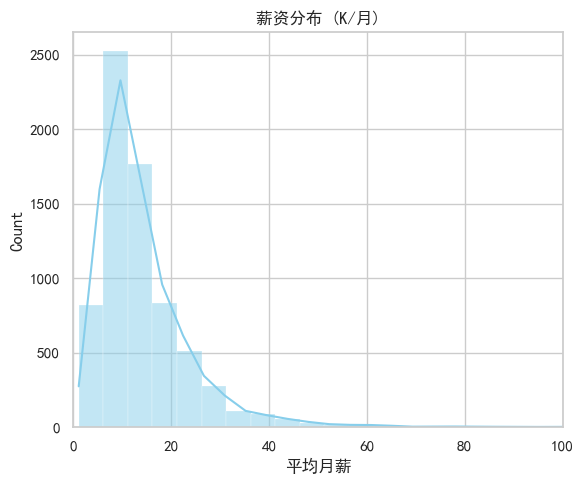

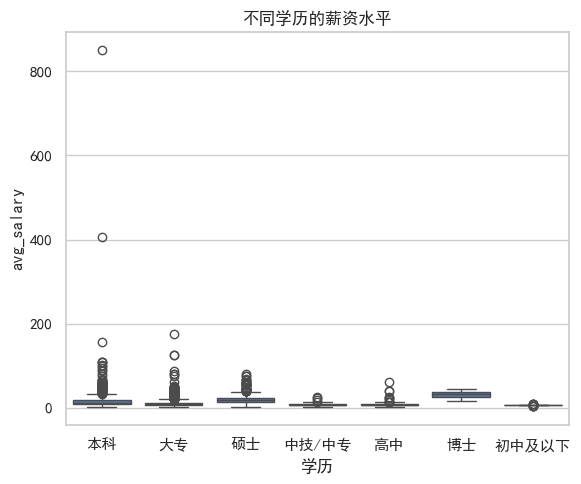

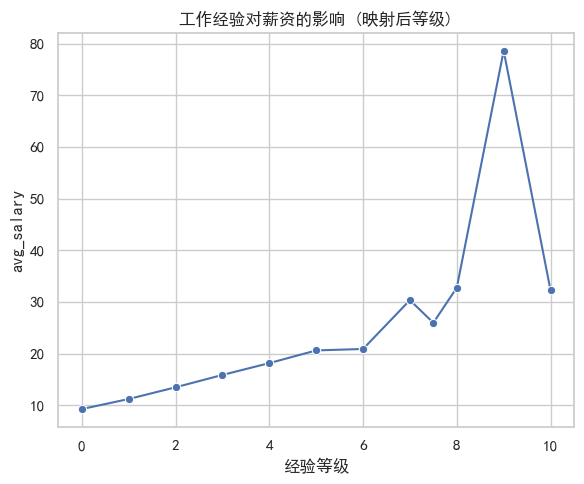

In [8]:
# 可视化：薪资分布、学历箱线图、经验趋势图
if wordcloud_font_path and os.path.exists(wordcloud_font_path):
    try:
        font_name = font_manager.FontProperties(fname=wordcloud_font_path).get_name()
        plt.rcParams['font.sans-serif'] = [font_name]
    except Exception:
        pass
plt.rcParams['axes.unicode_minus'] = False
# 1. 薪资分布直方图
fig, ax = plt.subplots(figsize=(6,5))
sns.histplot(df['avg_salary'], kde=True, ax=ax, color='skyblue')
ax.set_title('薪资分布 (K/月)')
ax.set_xlabel('平均月薪')
ax.set_xlim(0, 100)
plt.tight_layout()
plt.savefig('./website/data/picture/qcwy薪资分布.png', dpi=300, bbox_inches='tight')
plt.show()
# 2. 学历与薪资箱线图
fig, ax = plt.subplots(figsize=(6,5))
edu_order = list(df['学历'].dropna().unique())[:7]
sns.boxplot(x='学历', y='avg_salary', data=df, order=[x for x in edu_order if x in df['学历'].unique()], ax=ax)
ax.set_title('不同学历的薪资水平')
ax.set_xlabel('学历')
plt.tight_layout()
plt.savefig('./website/data/picture/qcwy学历薪资.png', dpi=300, bbox_inches='tight')
plt.show()
# 3. 经验与薪资趋势图
fig, ax = plt.subplots(figsize=(6,5))
exp_group = df.groupby('exp_level')['avg_salary'].mean().reset_index().sort_values('exp_level')
sns.lineplot(x='exp_level', y='avg_salary', data=exp_group, marker='o', ax=ax)
ax.set_title('工作经验对薪资的影响 (映射后等级)')
ax.set_xlabel('经验等级')
plt.tight_layout()
plt.savefig('./website/data/picture/qcwy经验薪资.png', dpi=300, bbox_inches='tight')
plt.show()

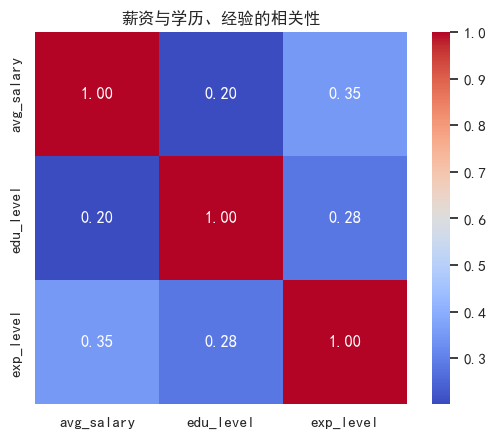

In [9]:
# 薪资、学历、经验的相关性热力图
corr_cols = ['avg_salary', 'edu_level', 'exp_level']
corr_df = df[corr_cols].dropna()
if not corr_df.empty:
    corr_matrix = corr_df.corr()
    plt.figure(figsize=(5.5,4.5))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('薪资与学历、经验的相关性')
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy薪资相关性热力图.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('无法计算相关性：有效数据为空。')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\xixif\AppData\Local\Temp\jieba.cache
Loading model cost 0.710 seconds.
Prefix dict has been built successfully.


Top20 关键词: [('五险', 4726), ('一金', 4290), ('补贴', 2901), ('绩效奖金', 2264), ('带薪', 2022), ('年终奖金', 1953), ('专业培训', 1691), ('体检', 1610), ('定期', 1600), ('培训', 1430), ('补充', 1315), ('双休', 1269), ('餐饮', 1104), ('节日', 1078), ('医疗保险', 1029), ('周末', 914), ('旅游', 781), ('通讯', 764), ('交通', 658), ('弹性', 313)]


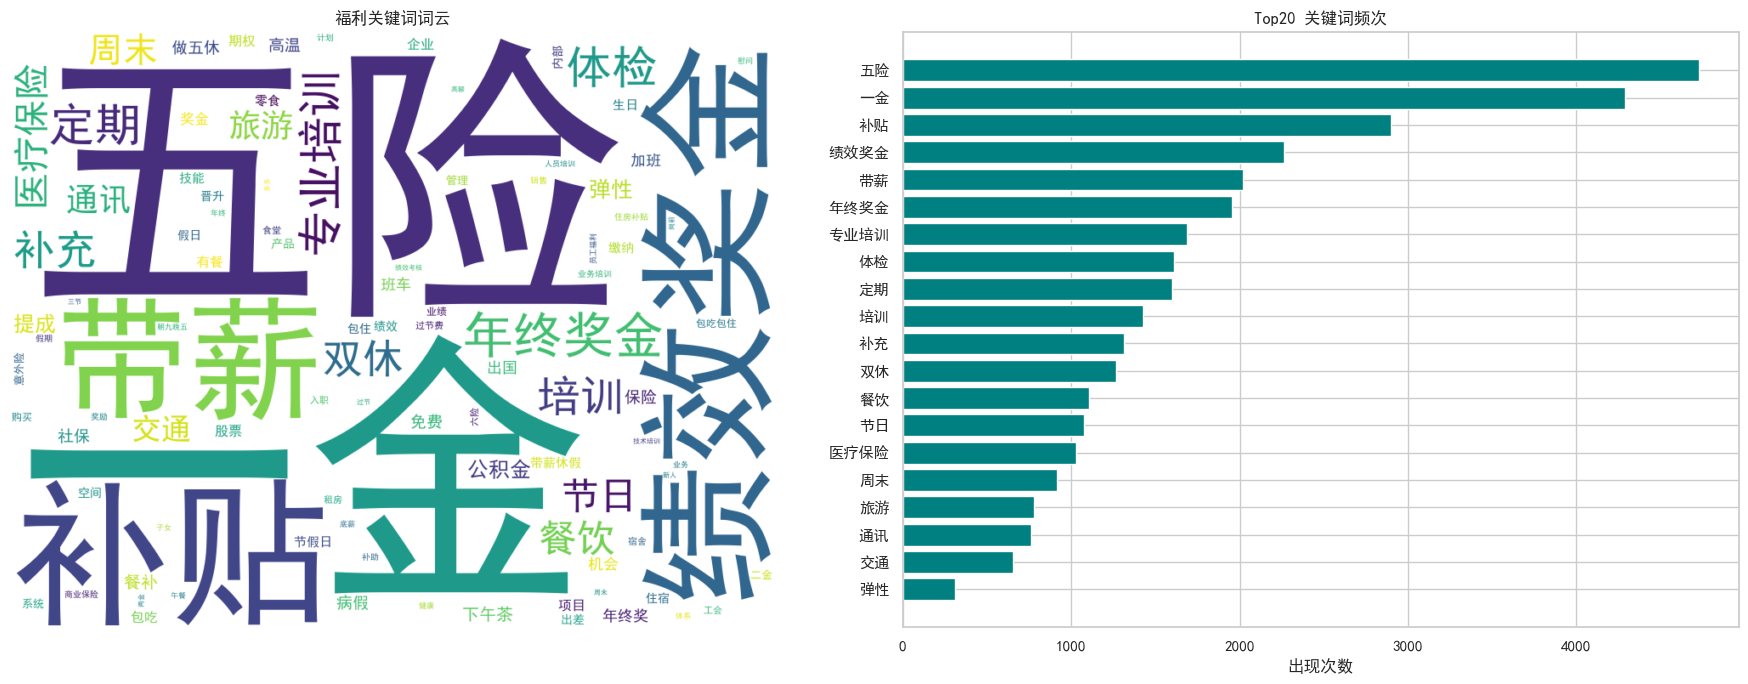

In [10]:
# 福利关键词词云与Top20统计
import jieba
from wordcloud import WordCloud
from collections import Counter
#text_series = df['职位描述'].fillna('') + ' ' + 
text_series = df['福利标签'].fillna('')
text_data = text_series.astype(str).str.cat(sep=' ')
if not text_data.strip():
    print('福利标签为空，无法生成词云。')
else:
    stopwords = set(['的','和','了','与','在','是','等','及','负责','进行','工作','相关','职位','要求','任职','优先','具有','具备','我们','岗位','薪资','福利','以上','学历','经验','不限','能够','熟练','团队','员工','公司','客户'])
    tokens = jieba.lcut(text_data)
    filtered_tokens = [w for w in tokens if w not in stopwords and len(w) > 1]
    if not filtered_tokens:
        print('过滤后无有效词汇，跳过词云生成。')
    else:
        freq = Counter(filtered_tokens)
        top20 = freq.most_common(20)
        print('Top20 关键词:', top20)
        wc_font = wordcloud_font_path
        if not wc_font or not os.path.exists(wc_font):
            fallback_fonts = plt.rcParams.get('font.sans-serif', [])
            for cand in fallback_fonts:
                try:
                    candidate_path = font_manager.findfont(cand)
                    if os.path.exists(candidate_path):
                        wc_font = candidate_path
                        break
                except Exception:
                    continue
        if not wc_font or not os.path.exists(wc_font):
            raise FileNotFoundError('未找到可用于词云的中文字体，请安装或在 _set_chinese_font 中配置。')
        fig, axes = plt.subplots(1, 2, figsize=(18,7))
        wc = WordCloud(font_path=wc_font, background_color='white', width=900, height=700, max_words=100, stopwords=stopwords)
        wc.generate_from_frequencies(freq)
        axes[0].imshow(wc, interpolation='bilinear')
        axes[0].axis('off')
        axes[0].set_title('福利关键词词云')
        if top20:
            words, counts = zip(*top20)
            axes[1].barh(words[::-1], counts[::-1], color='teal')
            axes[1].set_title('Top20 关键词频次')
            axes[1].set_xlabel('出现次数')
        else:
            axes[1].text(0.5, 0.5, '无有效关键词', ha='center', va='center')
            axes[1].axis('off')
        plt.tight_layout()
        plt.savefig('./website/data/picture/qcwy福利关键词词云与统计.png', dpi=300, bbox_inches='tight')
        plt.show()

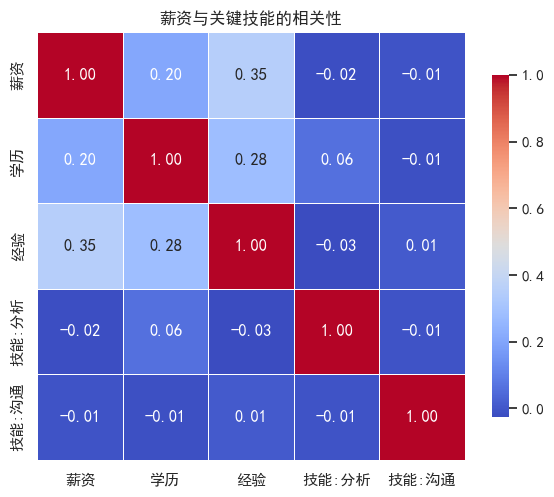

In [11]:
# 关键技能出现与薪资的相关性热力图
keyword_1 = '分析'
keyword_2 = '沟通'
text_col = df['职位描述'].fillna('')
skill_col = df['技能标签'].fillna('')
df['has_keyword_1'] = (text_col + skill_col).astype(str).str.contains(keyword_1).astype(int)
df['has_keyword_2'] = (text_col + skill_col).astype(str).str.contains(keyword_2).astype(int)
corr_features = df[['avg_salary', 'edu_level', 'exp_level', 'has_keyword_1', 'has_keyword_2']].dropna()
if corr_features.empty:
    print('无法绘制关键技能相关性热力图：有效数据为空。')
else:
    corr_features.columns = ['薪资','学历','经验', f'技能:{keyword_1}', f'技能:{keyword_2}']
    corr_matrix = corr_features.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink':0.8})
    plt.title('薪资与关键技能的相关性')
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy薪资关键技能相关性.png', dpi=300, bbox_inches='tight')
    plt.show()

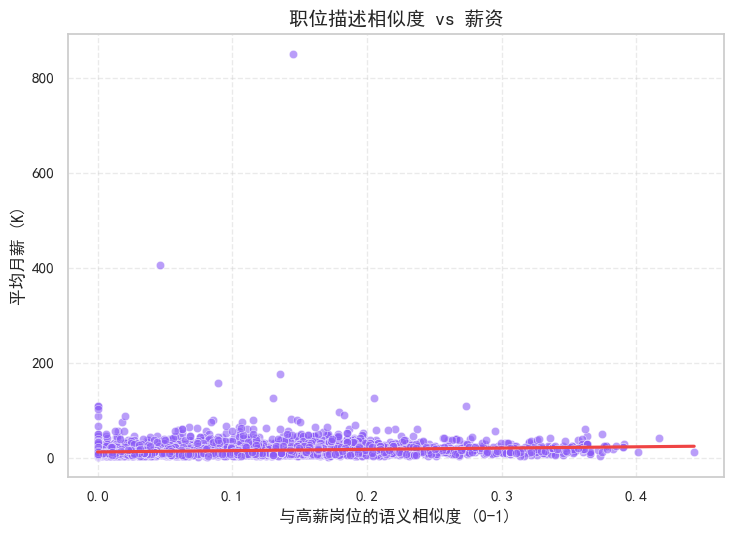

高薪门槛：25.00 K/月
相关系数：0.1366


In [12]:
# 职位描述语义相似度与薪资关系
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

content_series = (df['职位描述'].fillna('') + ' ' + df['技能标签'].fillna('')).str.strip()
valid_mask = content_series.astype(bool) & df['avg_salary'].notna()

if not valid_mask.any():
    print('无法计算职位描述相似度：缺少有效的文本或薪资数据。')
else:
    valid_df = df.loc[valid_mask].copy()
    valid_df['content'] = content_series[valid_mask]

    base_stopwords = stopwords if 'stopwords' in locals() else {
        '的','和','了','与','在','是','等','及','负责','进行','工作','相关','职位','要求','任职',
        '优先','具有','具备','我们','岗位','薪资','福利','以上','学历','经验','不限','能够','熟练','团队',
        '员工','公司','客户'
    }

    vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(base_stopwords))
    try:
        tfidf_matrix = vectorizer.fit_transform(valid_df['content'])
    except ValueError:
        print('职位描述文本不足，无法构建TF-IDF矩阵。')
    else:
        high_salary_threshold = df['avg_salary'].quantile(0.90)
        high_salary_docs = valid_df[valid_df['avg_salary'] >= high_salary_threshold]['content'].str.cat(sep=' ').strip()
        if not high_salary_docs:
            high_salary_docs = valid_df['content'].str.cat(sep=' ')

        high_salary_vector = vectorizer.transform([high_salary_docs])
        similarity_scores = cosine_similarity(tfidf_matrix, high_salary_vector).ravel()

        df['similarity_score'] = np.nan
        df.loc[valid_df.index, 'similarity_score'] = similarity_scores
        valid_df['similarity_score'] = similarity_scores

        plt.figure(figsize=(7.5, 5.5))
        sns.scatterplot(x='similarity_score', y='avg_salary', data=valid_df, alpha=0.6, color='#8b5cf6')
        sns.regplot(x='similarity_score', y='avg_salary', data=valid_df, scatter=False, color='#ef4444')
        plt.title('职位描述相似度 vs 薪资', fontsize=14)
        plt.xlabel('与高薪岗位的语义相似度 (0-1)')
        plt.ylabel('平均月薪 (K)')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.savefig('./website/data/picture/qcwy职位描述相似度与薪资关系.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f'高薪门槛：{high_salary_threshold:.2f} K/月')
        corr_value = valid_df['similarity_score'].corr(valid_df['avg_salary'])
        if corr_value is not None and not np.isnan(corr_value):
            print(f'相关系数：{corr_value:.4f}')
        else:
            print('相关系数无法计算：样本不足。')

C:\Users\xixif\AppData\Local\Temp\ipykernel_604\1448043598.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tier_salary.values, y=tier_salary.index, palette='viridis')


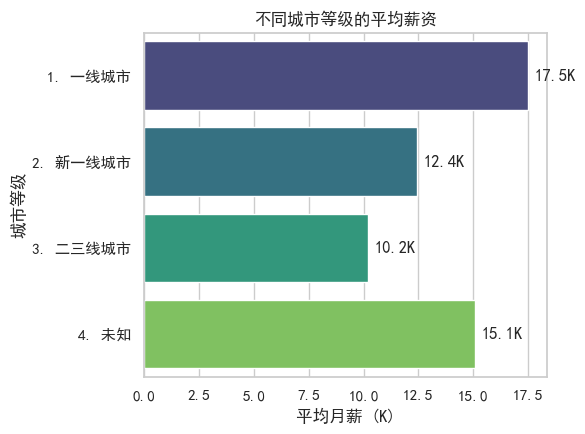

In [13]:
# 城市等级薪资差异
import re
def classify_city(city_name):
    if city_name is None or (isinstance(city_name, float) and pd.isna(city_name)):
        return '4. 未知'
    text = str(city_name).strip()
    if not text or text.lower() == 'none':
        return '4. 未知'
    text = text.replace('—', '-').replace('–', '-').replace('－', '-').replace('_', '-')
    raw_tokens = [t.strip() for t in re.split(r'[·／/\\\s-]+', text) if t.strip()]
    if not raw_tokens:
        return '4. 未知'
    processed_tokens = []
    for token in raw_tokens:
        cleaned = re.sub(r'(自治[区州市]|特别行政区)$', '', token)
        cleaned = re.sub(r'(经济开发区|开发区|高新区|新区|新城|老城区|城区)$', '', cleaned)
        cleaned = re.sub(r'(区|县|市)$', '', cleaned)
        cleaned = cleaned.replace('市县', '').strip()
        processed_tokens.append(cleaned or token)
    tier_map = {
        '北京': '1. 一线城市', '上海': '1. 一线城市', '广州': '1. 一线城市', '深圳': '1. 一线城市',
        '成都': '2. 新一线城市', '杭州': '2. 新一线城市', '重庆': '2. 新一线城市', '西安': '2. 新一线城市',
        '南京': '2. 新一线城市', '武汉': '2. 新一线城市', '苏州': '2. 新一线城市', '天津': '2. 新一线城市',
        '郑州': '2. 新一线城市', '长沙': '2. 新一线城市', '青岛': '2. 新一线城市', '宁波': '2. 新一线城市',
        '合肥': '2. 新一线城市', '佛山': '2. 新一线城市', '东莞': '2. 新一线城市',
        '无锡': '2. 新一线城市', '厦门': '2. 新一线城市', '大连': '2. 新一线城市', '沈阳': '2. 新一线城市',
        '昆明': '2. 新一线城市', '南昌': '2. 新一线城市', '贵阳': '2. 新一线城市', '福州': '2. 新一线城市',
        '泉州': '2. 新一线城市', '珠海': '2. 新一线城市', '中山': '2. 新一线城市', '烟台': '2. 新一线城市',
        '常州': '2. 新一线城市', '南通': '2. 新一线城市', '温州': '2. 新一线城市', '惠州': '2. 新一线城市',
        '嘉兴': '2. 新一线城市', '金华': '2. 新一线城市', '绍兴': '2. 新一线城市', '扬州': '2. 新一线城市',
        '济南': '2. 新一线城市', '潍坊': '2. 新一线城市', '洛阳': '2. 新一线城市', '徐州': '2. 新一线城市',
        '江阴': '2. 新一线城市', '长春': '2. 新一线城市',
    }
    for token in processed_tokens:
        if token in tier_map:
            return tier_map[token]
    for token in processed_tokens:
        for key, tier_val in tier_map.items():
            if key in token:
                return tier_val
    fallback = processed_tokens[0] or raw_tokens[0]
    if fallback in tier_map:
        return tier_map[fallback]
    for key, tier_val in tier_map.items():
        if key in fallback:
            return tier_val
    return '3. 二三线城市'
df['city_tier'] = df['地区'].apply(classify_city)
tier_salary = df.groupby('city_tier')['avg_salary'].mean().dropna().sort_index()
if not tier_salary.empty:
    plt.figure(figsize=(6,4.5))
    sns.barplot(x=tier_salary.values, y=tier_salary.index, palette='viridis')
    for idx, val in enumerate(tier_salary.values):
        plt.text(val + 0.3, idx, f'{val:.1f}K', va='center')
    plt.title('不同城市等级的平均薪资')
    plt.xlabel('平均月薪 (K)')
    plt.ylabel('城市等级')
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy城市等级薪资差异.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('城市等级薪资无法计算：缺少地区数据。')

C:\Users\xixif\AppData\Local\Temp\ipykernel_604\736239041.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scale_salary.values, y=scale_salary.index, palette='Blues_d')


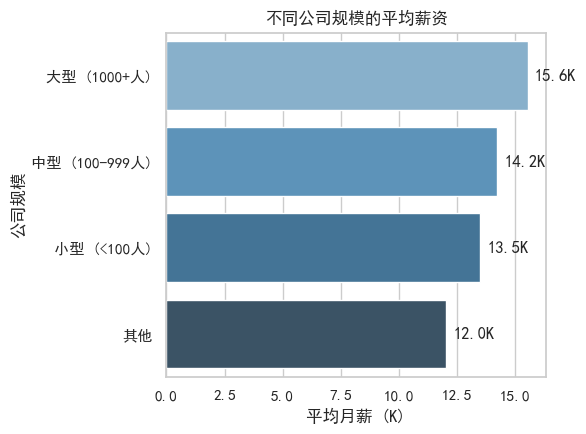

C:\Users\xixif\AppData\Local\Temp\ipykernel_604\736239041.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stage_salary.values, y=stage_salary.index, palette='Oranges')


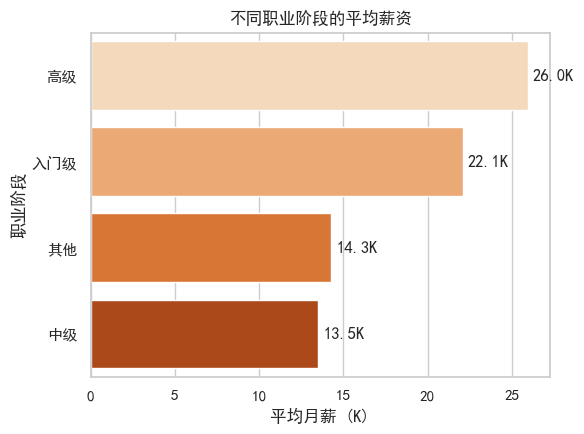

In [14]:
# 公司规模与职业阶段的薪资对比
def classify_scale(scale_text):
    if pd.isna(scale_text):
        return '其他'
    text = str(scale_text)
    match = re.search(r'(\d+)[^\d]+(\d+)人', text)
    if match:
        low = int(match.group(1))
        high = int(match.group(2))
        avg = (low + high) / 2
        if avg < 100:
            return '小型 (<100人)'
        if avg < 1000:
            return '中型 (100-999人)'
        return '大型 (1000+人)'
    if '以上' in text and re.search(r'\d+', text):
        return '大型 (1000+人)'
    if any(key in text for key in ['少于50', '少于100']):
        return '小型 (<100人)'
    return '其他'
df['scale_group'] = df['公司规模'].apply(classify_scale)
scale_salary = df.groupby('scale_group')['avg_salary'].mean().dropna().sort_values(ascending=False)
if not scale_salary.empty:
    plt.figure(figsize=(6,4.5))
    sns.barplot(x=scale_salary.values, y=scale_salary.index, palette='Blues_d')
    for idx, val in enumerate(scale_salary.values):
        plt.text(val + 0.3, idx, f'{val:.1f}K', va='center')
    plt.title('不同公司规模的平均薪资')
    plt.xlabel('平均月薪 (K)')
    plt.ylabel('公司规模')
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy公司规模薪资.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('缺少公司规模数据，无法绘制公司规模薪资图。')
def classify_stage(exp_text):
    if pd.isna(exp_text):
        return '其他'
    text = str(exp_text)
    if any(k in text for k in ['不限','应届','1年以内','一年以内']):
        return '入门级'
    if any(k in text for k in ['1-3年','一至三年','3-5年','三年以上']):
        return '中级'
    if any(k in text for k in ['5-10年','十年以上','10年以上','五年以上']):
        return '高级'
    return '其他'
df['stage_group'] = df['经验'].apply(classify_stage)
stage_salary = df.groupby('stage_group')['avg_salary'].mean().dropna().sort_values(ascending=False)
if not stage_salary.empty:
    plt.figure(figsize=(6,4.5))
    sns.barplot(x=stage_salary.values, y=stage_salary.index, palette='Oranges')
    for idx, val in enumerate(stage_salary.values):
        plt.text(val + 0.3, idx, f'{val:.1f}K', va='center')
    plt.title('不同职业阶段的平均薪资')
    plt.xlabel('平均月薪 (K)')
    plt.ylabel('职业阶段')
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy职业阶段薪资.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('缺少经验数据，无法绘制职业阶段薪资图。')

C:\Users\xixif\AppData\Local\Temp\ipykernel_604\3039179231.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_level = sim_df.groupby('sim_level')['avg_salary'].mean().dropna()
C:\Users\xixif\AppData\Local\Temp\ipykernel_604\3039179231.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_by_level.index, y=avg_by_level.values, palette='mako')


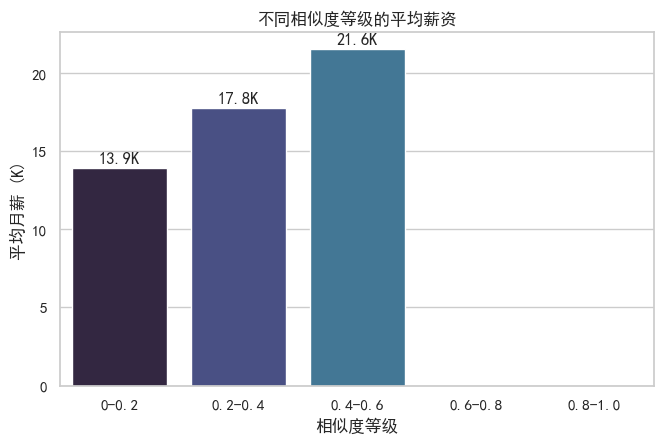

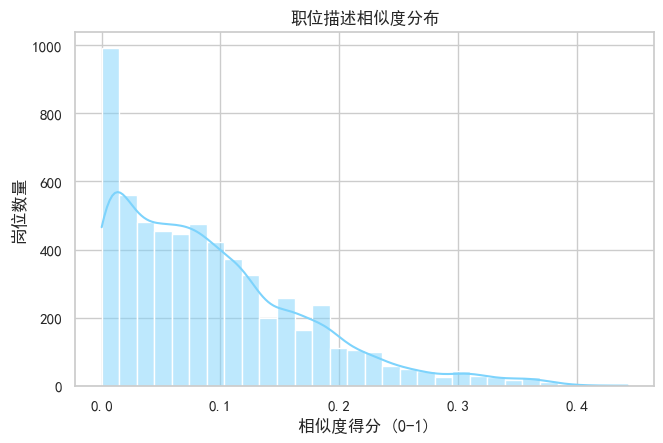

C:\Users\xixif\AppData\Local\Temp\ipykernel_604\3039179231.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='salary_group', y='similarity_score', data=sim_df, palette='Set2', width=0.55)


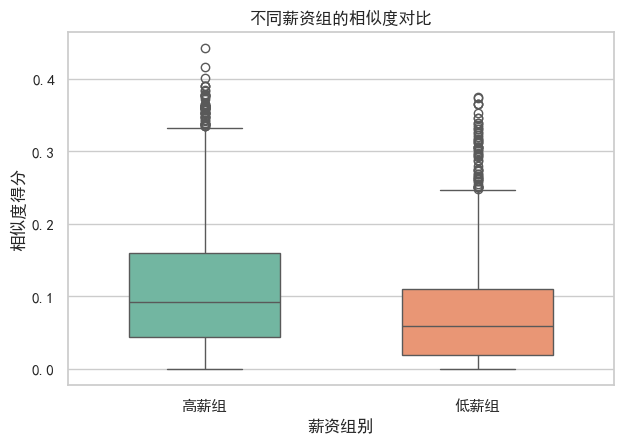

In [15]:
# 相似度等级与薪资分布综合分析
import numpy as np

if 'similarity_score' not in df.columns or df['similarity_score'].dropna().empty:
    print('尚未计算职位描述相似度，无法进行相似度分组分析。')
else:
    sim_df = df[['avg_salary', 'similarity_score']].dropna().copy()
    if sim_df.empty:
        print('缺少有效的薪资或相似度数据，无法绘制图表。')
    else:
        sim_df['sim_level'] = pd.cut(
            sim_df['similarity_score'],
            bins=np.linspace(0, 1, 6),
            labels=['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0'],
            include_lowest=True
        )

        avg_by_level = sim_df.groupby('sim_level')['avg_salary'].mean().dropna()
        if not avg_by_level.empty:
            plt.figure(figsize=(6.8, 4.6))
            sns.barplot(x=avg_by_level.index, y=avg_by_level.values, palette='mako')
            for idx, val in enumerate(avg_by_level.values):
                plt.text(idx, val + 0.3, f'{val:.1f}K', ha='center')
            plt.title('不同相似度等级的平均薪资')
            plt.xlabel('相似度等级')
            plt.ylabel('平均月薪 (K)')
            plt.tight_layout()
            plt.savefig('./website/data/picture/qcwy相似度等级与薪资关系.png', dpi=300, bbox_inches='tight')
            plt.show()

        plt.figure(figsize=(6.8, 4.6))
        sns.histplot(sim_df['similarity_score'], bins=30, kde=True, color='#7dd3fc')
        plt.title('职位描述相似度分布')
        plt.xlabel('相似度得分 (0-1)')
        plt.ylabel('岗位数量')
        plt.tight_layout()
        plt.savefig('./website/data/picture/qcwy相似度分布.png', dpi=300, bbox_inches='tight')
        plt.show()

        salary_median = sim_df['avg_salary'].median()
        sim_df['salary_group'] = np.where(sim_df['avg_salary'] >= salary_median, '高薪组', '低薪组')
        plt.figure(figsize=(6.4, 4.6))
        sns.boxplot(x='salary_group', y='similarity_score', data=sim_df, palette='Set2', width=0.55)
        plt.title('不同薪资组的相似度对比')
        plt.xlabel('薪资组别')
        plt.ylabel('相似度得分')
        plt.tight_layout()
        plt.savefig('./website/data/picture/qcwy薪资分组相似度箱线图.png', dpi=300, bbox_inches='tight')
        plt.show()

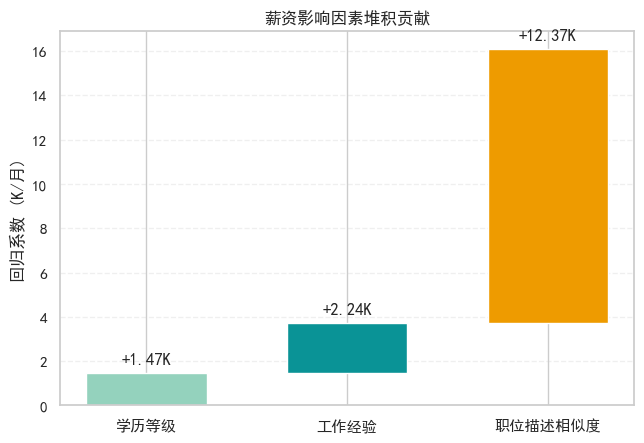

C:\Users\xixif\AppData\Local\Temp\ipykernel_604\839075997.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Value', y='Factor', data=impact_df, palette='flare')


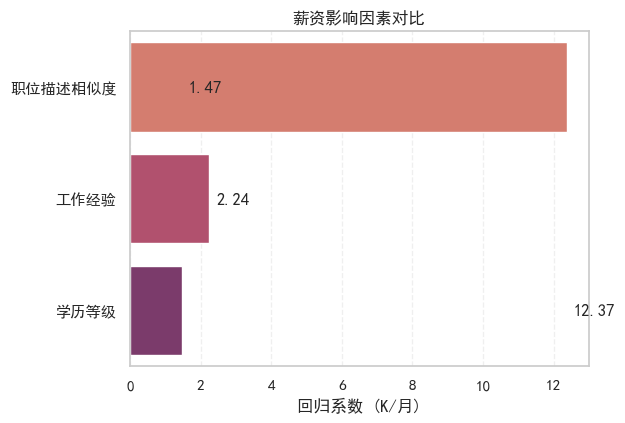

                            OLS Regression Results                            
Dep. Variable:             avg_salary   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     304.1
Date:                 周二, 23 12月 2025   Prob (F-statistic):          7.25e-184
Time:                        15:44:13   Log-Likelihood:                -24717.
No. Observations:                6036   AIC:                         4.944e+04
Df Residuals:                    6032   BIC:                         4.947e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.3542      0.575  

In [16]:
# 多元回归分析：学历、经验、描述相似度对薪资的影响
import statsmodels.api as sm

reg_cols = ['avg_salary', 'edu_level', 'exp_level', 'similarity_score']
reg_df = df[reg_cols].dropna().copy()

if reg_df.empty:
    print('缺少完整数据，无法进行多元回归分析。')
else:
    X = sm.add_constant(reg_df[['edu_level', 'exp_level', 'similarity_score']])
    model = sm.OLS(reg_df['avg_salary'], X).fit()

    coef_edu = model.params.get('edu_level', 0)
    coef_exp = model.params.get('exp_level', 0)
    coef_sim = model.params.get('similarity_score', 0)

    contributions = [coef_edu, coef_exp, coef_sim]
    labels = ['学历等级', '工作经验', '职位描述相似度']

    fig, ax = plt.subplots(figsize=(6.6, 4.6))
    base = 0
    colors = ['#94d2bd', '#0a9396', '#ee9b00']
    for idx, (label, value, color) in enumerate(zip(labels, contributions, colors)):
        ax.bar(label, value, bottom=base, color=color, width=0.6)
        base += value
        ax.text(idx, base + np.sign(value) * 0.4, f'{value:+.2f}K', ha='center', fontweight='bold')
    ax.set_title('薪资影响因素堆积贡献')
    ax.set_ylabel('回归系数 (K/月)')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy薪资影响因素堆积分析.png', dpi=300, bbox_inches='tight')
    plt.show()

    impact_df = (
        pd.DataFrame({'Factor': labels, 'Value': contributions})
        .sort_values('Value', ascending=False)
    )
    plt.figure(figsize=(6.4, 4.4))
    sns.barplot(x='Value', y='Factor', data=impact_df, palette='flare')
    for idx, row in impact_df.iterrows():
        plt.text(row['Value'] + 0.2 * np.sign(row['Value']), idx, f'{row["Value"]:.2f}', va='center')
    plt.title('薪资影响因素对比')
    plt.xlabel('回归系数 (K/月)')
    plt.ylabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy薪资影响因素对比.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_salary   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     97.42
Date:                 周二, 23 12月 2025   Prob (F-statistic):           1.42e-61
Time:                        15:44:16   Log-Likelihood:                -25000.
No. Observations:                6036   AIC:                         5.001e+04
Df Residuals:                    6032   BIC:                         5.003e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.2543      0.868  

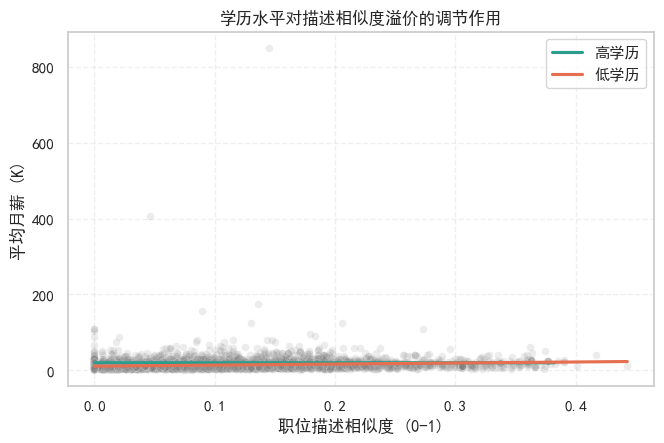

In [17]:
# 学历对描述相似度溢价的调节效应
interaction_df = df[['avg_salary', 'edu_level', 'similarity_score']].dropna().copy()

if interaction_df.empty:
    print('数据不足，无法分析学历与相似度的交互作用。')
else:
    interaction_df['edu_x_skill'] = interaction_df['edu_level'] * interaction_df['similarity_score']
    X_mech = sm.add_constant(interaction_df[['edu_level', 'similarity_score', 'edu_x_skill']])
    model_mech = sm.OLS(interaction_df['avg_salary'], X_mech).fit()
    print(model_mech.summary())

    median_edu = interaction_df['edu_level'].median()
    high_edu = interaction_df[interaction_df['edu_level'] > median_edu]
    low_edu = interaction_df[interaction_df['edu_level'] <= median_edu]

    plt.figure(figsize=(6.8, 4.6))
    if not high_edu.empty:
        sns.regplot(
            x='similarity_score', y='avg_salary',
            data=high_edu,
            scatter=False,
            label='高学历',
            color='#2a9d8f'
        )
    if not low_edu.empty:
        sns.regplot(
            x='similarity_score', y='avg_salary',
            data=low_edu,
            scatter=False,
            label='低学历',
            color='#e76f51'
        )
    sns.scatterplot(x='similarity_score', y='avg_salary', data=interaction_df, alpha=0.15, color='gray', s=30)
    plt.title('学历水平对描述相似度溢价的调节作用')
    plt.xlabel('职位描述相似度 (0-1)')
    plt.ylabel('平均月薪 (K)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('./website/data/picture/qcwy学历对技能溢价调节作用.png', dpi=300, bbox_inches='tight')
    plt.show()

      Type          Group    Coef P_value     N
0  A. 公司规模  中型 (100-999人)    9.00   0.003  2388
2  A. 公司规模     小型 (<100人)   11.43   0.029   677
1  A. 公司规模    大型 (1000+人)   13.61   0.015  2103
4  B. 职业阶段             高级  -10.36   0.735    28
3  B. 职业阶段             中级    8.72   0.084   284


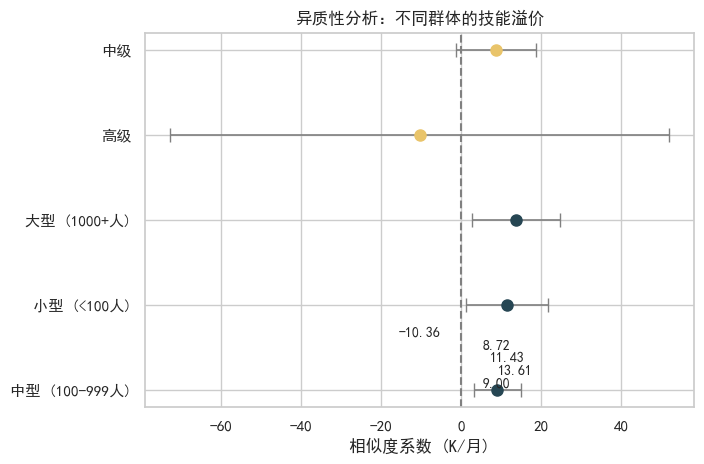

In [18]:
# 异质性分析：公司规模与职业阶段下的技能溢价
hetero_required = {'scale_group', 'stage_group', 'similarity_score', 'edu_level', 'exp_level', 'avg_salary'}
if not hetero_required.issubset(df.columns):
    print('缺少必要列，无法执行异质性分析。')
else:
    base_df = df[list(hetero_required)].dropna()
    if base_df.empty:
        print('有效样本不足，异质性分析跳过。')
    else:
        def run_group_regression(data, group_col, label):
            records = []
            for group_name, sub_df in data.groupby(group_col):
                if group_name == '其他' or len(sub_df) < 8:
                    continue
                X = sm.add_constant(sub_df[['similarity_score', 'edu_level', 'exp_level']])
                try:
                    model = sm.OLS(sub_df['avg_salary'], X).fit()
                    coef = model.params.get('similarity_score', np.nan)
                    conf_int = model.conf_int().loc['similarity_score'] if 'similarity_score' in model.params else [np.nan, np.nan]
                    error = coef - conf_int[0] if np.isfinite(coef) else np.nan
                    records.append({
                        'Type': label,
                        'Group': group_name,
                        'Coef': coef,
                        'Error': error,
                        'P_value': model.pvalues.get('similarity_score', np.nan),
                        'N': len(sub_df)
                    })
                except Exception as e:
                    print(f'{label}-{group_name} 回归失败: {e}')
            return records

        results = run_group_regression(base_df, 'scale_group', 'A. 公司规模') + \
                   run_group_regression(base_df, 'stage_group', 'B. 职业阶段')
        if not results:
            print('异质性分析结果为空。')
        else:
            result_df = pd.DataFrame(results)
            result_df = result_df.sort_values(['Type', 'Coef'])
            display_cols = result_df[['Type', 'Group', 'Coef', 'P_value', 'N']].copy()
            display_cols['Coef'] = display_cols['Coef'].apply(lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN')
            display_cols['P_value'] = display_cols['P_value'].apply(lambda x: f'{x:.3f}' if pd.notna(x) else 'NaN')
            print(display_cols)

            plt.figure(figsize=(7.2, 4.8))
            color_map = {'A. 公司规模': '#264653', 'B. 职业阶段': '#e9c46a'}
            for idx, row in result_df.iterrows():
                if pd.isna(row['Coef']):
                    continue
                plt.errorbar(
                    x=row['Coef'], y=row['Group'],
                    xerr=row['Error'] if pd.notna(row['Error']) else None,
                    fmt='o', capsize=5, markersize=8,
                    color=color_map.get(row['Type'], '#457b9d'),
                    ecolor='gray', elinewidth=1.2
                )
                plt.text(row['Coef'], idx * 0.15, f'{row["Coef"]:.2f}', fontsize=10, ha='center', va='bottom')
            plt.axvline(0, color='gray', linestyle='--')
            plt.title('异质性分析：不同群体的技能溢价')
            plt.xlabel('相似度系数 (K/月)')
            plt.tight_layout()
            plt.savefig('./website/data/picture/qcwy技能溢价异质性分析.png', dpi=300, bbox_inches='tight')
            plt.show()

  City_Tier   Coef P_value     N
3     4. 未知  66.17   0.008    29
0   1. 一线城市  10.82   0.036  2502
1  2. 新一线城市  10.48   0.000  2826
2  3. 二三线城市   8.16   0.022   679


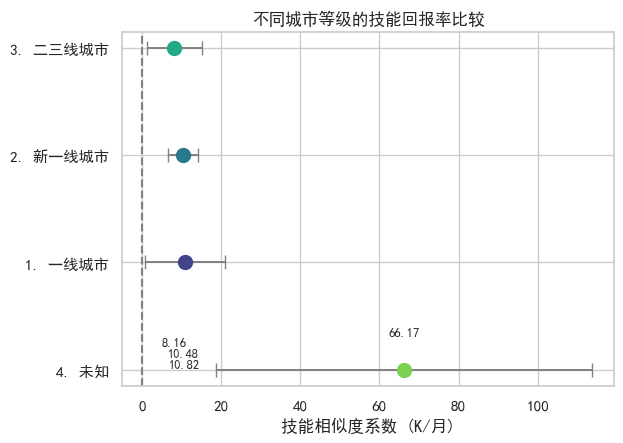

In [19]:
# 地区差异：城市等级下的技能回报率
if 'city_tier' not in df.columns:
    print('缺少城市等级数据，跳过地区差异分析。')
else:
    city_df = df[['city_tier', 'avg_salary', 'edu_level', 'exp_level', 'similarity_score']].dropna().copy()
    if city_df.empty:
        print('城市等级样本不足，无法进行分析。')
    else:
        records = []
        for city_name, sub_df in city_df.groupby('city_tier'):
            if len(sub_df) < 15:
                continue
            X = sm.add_constant(sub_df[['similarity_score', 'edu_level', 'exp_level']])
            try:
                model = sm.OLS(sub_df['avg_salary'], X).fit()
                coef = model.params.get('similarity_score', np.nan)
                conf_int = model.conf_int().loc['similarity_score'] if 'similarity_score' in model.params else [np.nan, np.nan]
                error = coef - conf_int[0] if pd.notna(coef) else np.nan
                records.append({
                    'City_Tier': city_name,
                    'Coef': coef,
                    'Error': error,
                    'P_value': model.pvalues.get('similarity_score', np.nan),
                    'N': len(sub_df)
                })
            except Exception as e:
                print(f'{city_name} 回归失败: {e}')
        if not records:
            print('没有满足样本量要求的城市等级。')
        else:
            res_city = pd.DataFrame(records).sort_values('Coef', ascending=False)
            display_cols = res_city[['City_Tier', 'Coef', 'P_value', 'N']].copy()
            display_cols['Coef'] = display_cols['Coef'].apply(lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN')
            display_cols['P_value'] = display_cols['P_value'].apply(lambda x: f'{x:.3f}' if pd.notna(x) else 'NaN')
            print(display_cols)

            plt.figure(figsize=(6.4, 4.6))
            palette = sns.color_palette('viridis', len(res_city))
            for idx, row in res_city.iterrows():
                if pd.isna(row['Coef']):
                    continue
                plt.errorbar(
                    x=row['Coef'], y=row['City_Tier'],
                    xerr=row['Error'] if pd.notna(row['Error']) else None,
                    fmt='o', capsize=5, markersize=10,
                    color=palette[idx], ecolor='gray', elinewidth=1.4
                )
                plt.text(row['Coef'], idx * 0.1, f'{row["Coef"]:.2f}', ha='center', va='bottom', fontsize=9)
            plt.axvline(0, color='gray', linestyle='--')
            plt.title('不同城市等级的技能回报率比较')
            plt.xlabel('技能相似度系数 (K/月)')
            plt.tight_layout()
            plt.savefig('./website/data/picture/qcwy城市等级技能回报率.png', dpi=300, bbox_inches='tight')
            plt.show()

匹配前薪资差异: 3.61 K
匹配后薪资差异: -0.78 K


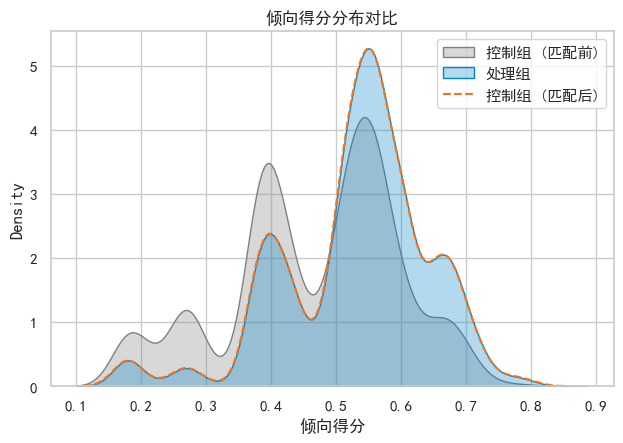

In [20]:
# 倾向得分匹配：验证高描述相似度对薪资的影响
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

psm_cols = ['avg_salary', 'edu_level', 'exp_level', 'similarity_score']
psm_df = df[psm_cols].dropna().copy()

if psm_df.empty or psm_df['similarity_score'].nunique() < 2:
    print('样本不足或相似度缺乏差异，无法进行倾向得分匹配。')
else:
    threshold = psm_df['similarity_score'].median()
    psm_df['treatment'] = (psm_df['similarity_score'] > threshold).astype(int)
    if psm_df['treatment'].nunique() < 2:
        print('处理组与对照组无法区分，跳过匹配分析。')
    else:
        X_covars = psm_df[['edu_level', 'exp_level']]
        y_treat = psm_df['treatment']

        ps_model = LogisticRegression(max_iter=1000)
        ps_model.fit(X_covars, y_treat)
        psm_df['ps_score'] = ps_model.predict_proba(X_covars)[:, 1]

        treated = psm_df[psm_df['treatment'] == 1]
        control = psm_df[psm_df['treatment'] == 0]

        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(control[['ps_score']])
        distances, indices = nn.kneighbors(treated[['ps_score']])
        matched_control = control.iloc[indices.flatten()].copy()

        diff_before = treated['avg_salary'].mean() - control['avg_salary'].mean()
        diff_after = treated['avg_salary'].mean() - matched_control['avg_salary'].mean()

        print(f'匹配前薪资差异: {diff_before:.2f} K')
        print(f'匹配后薪资差异: {diff_after:.2f} K')

        plt.figure(figsize=(6.4, 4.6))
        sns.kdeplot(control['ps_score'], label='控制组 (匹配前)', fill=True, alpha=0.3, color='gray')
        sns.kdeplot(treated['ps_score'], label='处理组', fill=True, alpha=0.3, color='#0284c7')
        sns.kdeplot(matched_control['ps_score'], label='控制组 (匹配后)', linestyle='--', color='#f97316')
        plt.title('倾向得分分布对比')
        plt.xlabel('倾向得分')
        plt.legend()
        plt.tight_layout()
        plt.savefig('./website/data/picture/qcwy倾向得分匹配效果验证.png', dpi=300, bbox_inches='tight')
        plt.show()

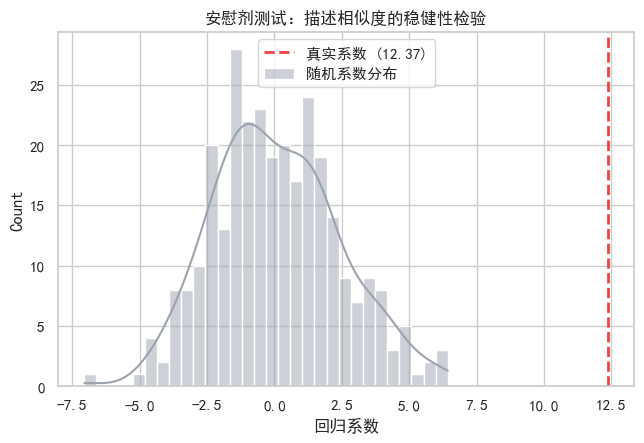

In [21]:
# 稳健性检验：安慰剂测试验证显著性
placebo_df = df[['avg_salary', 'edu_level', 'exp_level', 'similarity_score']].dropna().copy()

if placebo_df.empty:
    print('数据不足，无法执行安慰剂测试。')
else:
    base_model = sm.OLS(
        placebo_df['avg_salary'],
        sm.add_constant(placebo_df[['similarity_score', 'edu_level', 'exp_level']])
    ).fit()
    true_coef = base_model.params.get('similarity_score', np.nan)
    if pd.isna(true_coef):
        print('基准模型未获得有效系数。')
    else:
        n_sim = 300
        fake_coefs = []
        for _ in range(n_sim):
            shuffled = placebo_df['similarity_score'].sample(frac=1, replace=False).values
            temp = placebo_df.copy()
            temp['fake_similarity'] = shuffled
            model_fake = sm.OLS(
                temp['avg_salary'],
                sm.add_constant(temp[['fake_similarity', 'edu_level', 'exp_level']])
            ).fit()
            fake_coefs.append(model_fake.params.get('fake_similarity', np.nan))
        fake_coefs = [c for c in fake_coefs if pd.notna(c)]
        if not fake_coefs:
            print('安慰剂测试未生成有效结果。')
        else:
            plt.figure(figsize=(6.6, 4.6))
            sns.histplot(fake_coefs, bins=30, kde=True, color='#9ca3af', label='随机系数分布')
            plt.axvline(true_coef, color='#ef4444', linestyle='--', linewidth=2, label=f'真实系数 ({true_coef:.2f})')
            plt.title('安慰剂测试：描述相似度的稳健性检验')
            plt.xlabel('回归系数')
            plt.legend()
            plt.tight_layout()
            plt.savefig('./website/data/picture/qcwy安慰剂测试稳健性检验.png', dpi=300, bbox_inches='tight')
            plt.show()